# UNet implementation with complementary tools to try different approaches
Based on https://youtu.be/u1loyDCoGbE for implementation of U-net : https://arxiv.org/pdf/1505.04597.pdf

This notebook is the reference notebook of our implementation, and we will make copies of it, to test different small changes and compare their results.

See cell 6 for general parameters which will change frequently. Otherwise changes will be details here in this cell.

## Specific test details

This try will be of 30 epochs training on 30 of the first images we have in our dataset. 

We will use SGD without inertia, and CrossEntropy loss. This SGD is changed from the default notebook Adam in the cell where we launch the training. The original code is commented out (kept for reference)

learning rate = 1e-4

In [6]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2 as cv
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
env = "colab" # local or colab
train_or_load = "train" # train or load : Are we training a model, or just loading a pretrained one ?

In [12]:
#Google Colab specifics
if env == "colab":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !cp "/content/drive/MyDrive/helpers.py" .
    imgs_names = glob.glob( '/content/drive/MyDrive/th_analysedimages/*.tif')
    labels_names = glob.glob('/content/drive/MyDrive/labels/*.png')

Mounted at /content/drive


In [13]:
#Local github project specifics
if env == "local":
    imgs_names = glob.glob( '/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/th_analysedimages/*.tif')
    labels_names = glob.glob('/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/th_csv_labels/png_masks_emb/*.png')
    !cp "/Users/theophanemayaud/Dev/EPFL MA1/Machine Learning/cs-433-project-2-ml_fools/helpers.py" .

In [14]:
from helpers import png_to_mask, segment_dataset, compute_emb_surf_pred_error, confusion, out_predict

imgs_names= sorted(imgs_names)
#imgs = [cv.imread(name, cv.IMREAD_UNCHANGED) for name in imgs_names[1]]
print(f"Found {len(imgs_names)} images")

labels_names= sorted(labels_names)
#labels = [png_to_mask(cv.imread(name, cv.IMREAD_UNCHANGED)) for name in labels_names]
print(f"Found {len(labels_names)} labels")

Found 357 images
Found 357 labels


## General parameters are here :

In [20]:
# Training configuration parameters
learning_rate = 1e-4

num_epochs= 30
number_of_images = 30
train_img_pathnames = imgs_names[:number_of_images]
train_label_pathnames = labels_names[:number_of_images]

disp_every_x_epoch = 10
disp_every_x_img = 10
max_seg_to_disp = 9    # NB 1 (and not 0) means the first segment is displayed
disp_every_x_seg = 4

# Testing predictions parameters
test_img_start = 300
test_img_stop = 330
test_img_pathnames = imgs_names[test_img_start:test_img_stop]
test_label_pathnames = labels_names[test_img_start:test_img_stop]

print_each_test_stat = False

# Saving parameters when in train mode
model_name = "30epoch30firstImgLr1e-4SGDnoInertiaCrossEntro"
model_description = "None"

UNet picture representation : 

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="300">

In [16]:
# Define the device to train on, if a GPU is available (ex when on Google Colab)
if not torch.cuda.is_available():
    print("Things will go much quicker if you enable a GPU, ex in Colab under 'Runtime / Change Runtime Type'")
else:
    #del model # only needed when re-running multiple times
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device is: {device}\n")

Selected device is: cuda



In [17]:
# UNet definitions
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # functions for going down the U
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d_double_conv_1 = double_conv(1, 64)
        self.d_double_conv_2 = double_conv(64, 128)
        self.d_double_conv_3 = double_conv(128, 256)
        self.d_double_conv_4 = double_conv(256, 512)
        self.d_double_conv_5 = double_conv(512, 1024)
        
        # functions for going up the U
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)        
        self.u_double_conv_4 = double_conv(1024, 512)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.u_double_conv_3 = double_conv(512, 256)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.u_double_conv_2 = double_conv(256, 128)
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.u_double_conv_1 = double_conv(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)
        
    def forward(self, image):
        '''makes the 388x388 prediction with the model, image must be 572x572pixels'''
        
        # Going down the U
        d1 = self.d_double_conv_1(image) # first "level"
        # print(x1.size())
        x = self.max_pool_2x2(d1)
        d2 = self.d_double_conv_2(x) # second
        x = self.max_pool_2x2(d2)
        d3 = self.d_double_conv_3(x) # third
        x = self.max_pool_2x2(d3)
        d4 = self.d_double_conv_4(x) # fourth
        x = self.max_pool_2x2(d4)
        x = self.d_double_conv_5(x) # last layer (fifth) : no max pool
        # plt.imshow(x.detach().numpy()[0, 0, :, :])
        
        # Going up the U
        x = self.up_trans_4(x)
        d4 = crop_img(tensor=d4, target_tensor=x) #crop to copy
        x = self.u_double_conv_4(torch.cat([d4, x], 1))
        
        x = self.up_trans_3(x)
        d3 = crop_img(tensor=d3, target_tensor=x)
        x = self.u_double_conv_3(torch.cat([d3, x], 1))
        
        x = self.up_trans_2(x)
        d2 = crop_img(tensor=d2, target_tensor=x)
        x = self.u_double_conv_2(torch.cat([d2, x], 1))
        
        x = self.up_trans_1(x)
        d1 = crop_img(tensor=d1, target_tensor=x)
        x = self.u_double_conv_1(torch.cat([d1, x], 1))
        
        x = self.out(x)
        return x
        
        
    
# some functions so reduce redunduncy
def double_conv(nb_in_channels, nb_out_channels): # Used for every descending step
    conv = nn.Sequential(
        nn.Conv2d(nb_in_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(nb_out_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor): # Used for copy and crop between descending and ascending
    target_size = target_tensor.size()[2] # NB they are square so .size[2]=.size[3]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size #target is always smaller
    pix_crop = delta // 2
    return tensor[:, :, pix_crop:tensor_size-pix_crop, pix_crop:tensor_size-pix_crop]

In [18]:
# Training function
def train_model(model, img_pathnames, label_pathnames, criterion, optimizer, device, num_epochs=25, 
                disp_every_x_epoch = 1,
                disp_every_x_img = 1,
                max_seg_to_disp = 100, # NB 1 (and not 0) means the first segment is displayed
                disp_every_x_seg = 1):
    points=0 # incrementer for displaying progress

    print("Starting the training on images !")
    model.train()
    for epoch in range(num_epochs):
        
        for image_i in range(len(img_pathnames)):
            image = cv.imread(img_pathnames[image_i], cv.IMREAD_UNCHANGED)
            label = png_to_mask(cv.imread(label_pathnames[image_i], cv.IMREAD_UNCHANGED))
            
            image_segments, label_segments = segment_dataset([image], [label])
            
            for segment_i in range(len(image_segments[:, 0, 0])):
                since = time.process_time() # For process monitoring
                img_seg = torch.tensor(image_segments[segment_i, :, :], requires_grad=True).view(1, 1, 572, 572).to(device).float()
                label_seg = torch.tensor(label_segments[segment_i, :, :].astype(float)).view(1, 388, 388).to(device).long()
                
                prediction = model(img_seg)
                loss = criterion(prediction, label_seg)
            
                # Compute the gradient
                optimizer.zero_grad()
                loss.backward()
                
                # Update the parameters of the model with a gradient step
                optimizer.step()
                            
                # Optionnaly display status during training
                if ( epoch%disp_every_x_epoch==0 and image_i%disp_every_x_img==0 
                        and segment_i%disp_every_x_seg==0 and segment_i<max_seg_to_disp-1 ): 
                    if image_i==0 and segment_i==0:
                        print(f"\nEpoch {1+epoch}/{num_epochs}", end="")
                    if segment_i==0:
                        print(f"\n|  Image {1+image_i}/{len(img_pathnames)} '{img_pathnames[image_i]}'", end="")
                
                    time_elapsed = time.process_time()-since

                    # Make new prediction so compare before and after step
                    new_prediction = model(img_seg)
                    new_loss = criterion(new_prediction, label_seg)
                    ori_lab_seg = label_seg.cpu().detach().numpy()[0,:,:].astype(int)
                    pred_lab_seg = torch.argmax(prediction, dim=1).cpu().detach().numpy()[0, :, :]

                    emb_surf_pred_error = compute_emb_surf_pred_error(ori_lab_seg, pred_lab_seg, print_values=False)
                    print(f"\n|  |  Segment {1+segment_i}/{len(image_segments[:, 0, 0])} : loss={loss} "+\
                          f"duration={int(time_elapsed)//60}m {int(time_elapsed%60)}s. Loss reduced {loss-new_loss}. "+\
                          f"Emb surf pred err= {emb_surf_pred_error}%", end="")
                        
                    # # Also optionally print confusion values :
                    # print(f"\n|  |  Confusion values are :{confusion(ori_lab_seg, pred_lab_seg, data_type='numpy')}")

                    # # Also optionnaly print image segment, label and prediction
                    # _ , axs = plt.subplots(ncols=3, figsize=(40, 40))
                    # axs[0].set_title("Segment of original image")
                    # axs[0].imshow(img_seg.cpu().detach().numpy()[0,0,:,:])
                    # axs[1].set_title("Segment of original label")
                    # axs[1].imshow(label_seg.cpu().detach().numpy()[0,:,:])
                    # axs[2].set_title("Predicted label segment")
                    # axs[2].imshow(torch.argmax(prediction, dim=1).cpu().detach().numpy()[0,:,:])
                    # plt.show()
                    points=0

                if ( (epoch%disp_every_x_epoch==0 and image_i%disp_every_x_img==1 and segment_i==0) 
                        or (epoch%disp_every_x_epoch==1 and points==0) ):
                    print("\n   ...Next epochs & images ", end="")
                    points = 1
                else:
                    print(".", end="")
                    points = points+1 
                    if  points>80:
                        print("\n      ...", end="")
                        points = 1

    print("\n\n Finished training")

In [19]:
# Actually training the model
if train_or_load == "train" : 
    
    model = UNet().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_model(model, train_img_pathnames, train_label_pathnames, criterion, optimizer, device, num_epochs,
                disp_every_x_epoch,
                disp_every_x_img,
                max_seg_to_disp,
                disp_every_x_seg)

Starting the training on images !

Epoch 1/30
|  Image 1/30 '/content/drive/MyDrive/th_analysedimages/Session1_flushed_1-fs-08_311.tif'
|  |  Segment 1/6 : loss=314.2270812988281 duration=0m 0s. Loss reduced -12981.4970703125. Emb surf pred err= 3670.197846230904%....
|  |  Segment 5/6 : loss=10.569025993347168 duration=0m 0s. Loss reduced -32.63227462768555. Emb surf pred err= -678800.0%..
   ...Next epochs & images ................................................................................
      ........
|  Image 11/30 '/content/drive/MyDrive/th_analysedimages/Session1_flushed_1-qp-11_786.tif'
|  |  Segment 1/9 : loss=0.7372785806655884 duration=0m 0s. Loss reduced 0.0006763935089111328. Emb surf pred err= -15355.172413793103%....
|  |  Segment 5/9 : loss=0.9648721814155579 duration=0m 0s. Loss reduced 0.005257308483123779. Emb surf pred err= -26572.727272727272%.....
   ...Next epochs & images ................................................................................
    

In [21]:
# Loading the pre-trained model
if train_or_load == "load":  
    PATH = "/content/drive/MyDrive/savedmodels/" + model_name + ".pkl"
    if env == "local":
        PATH = "./savedmodels/" + model_name + ".pkl"

    if device == "cuda":
        map_to_device = "cuda:0"
    else:
        map_to_device = "cpu"

    model = UNet()

    checkpoint = torch.load(PATH)

    print("Model parameters are :")
    print(f"   name : {checkpoint['name']}")
    print(f"   description : {checkpoint['description']}")
    model.load_state_dict(checkpoint['model_state_dict'])
    # # If wanting to resume training :
    # optimizer = TheOptimizerClass(*args, **kwargs)
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model.to(device)
    print("Model successfully loaded !")

Starting testing predictions 

..............................
Last image looks like :


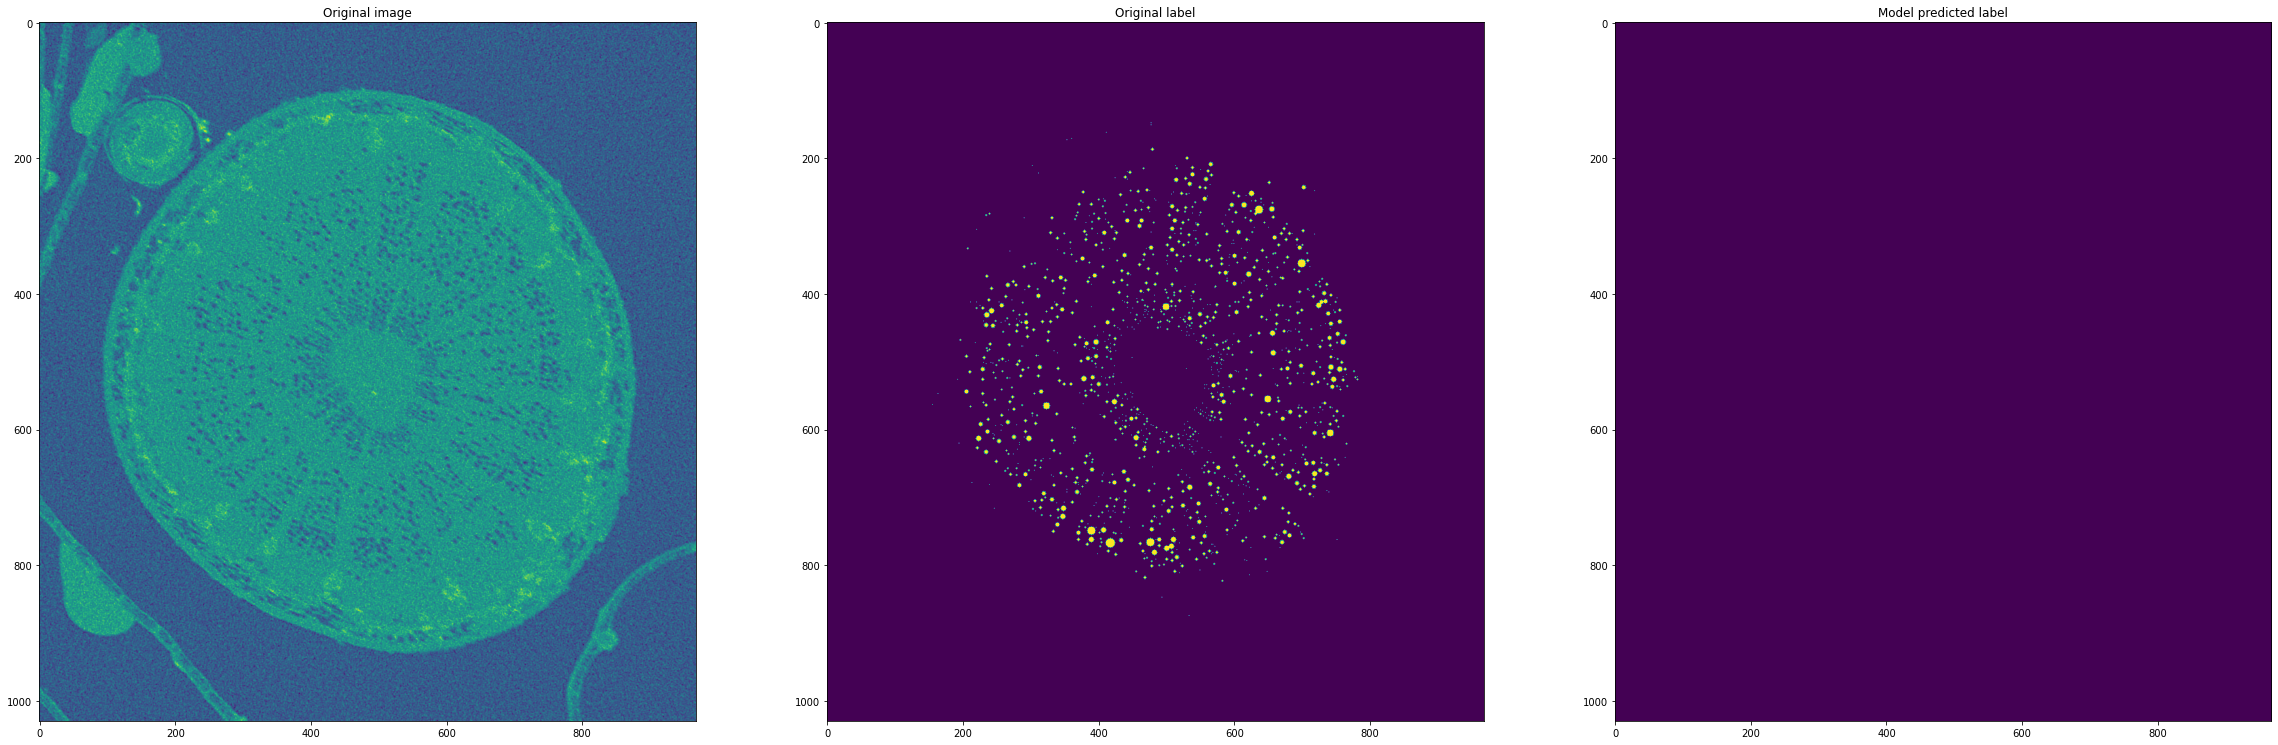

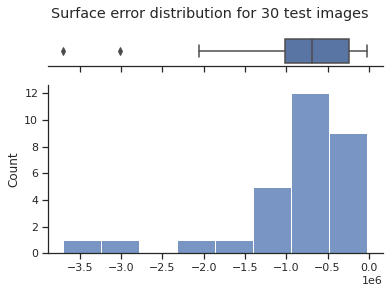

Finished testing with mean surface error=-855296.6666666666%


Check of performance on training set :
Starting testing predictions 

..............................
Last image looks like :


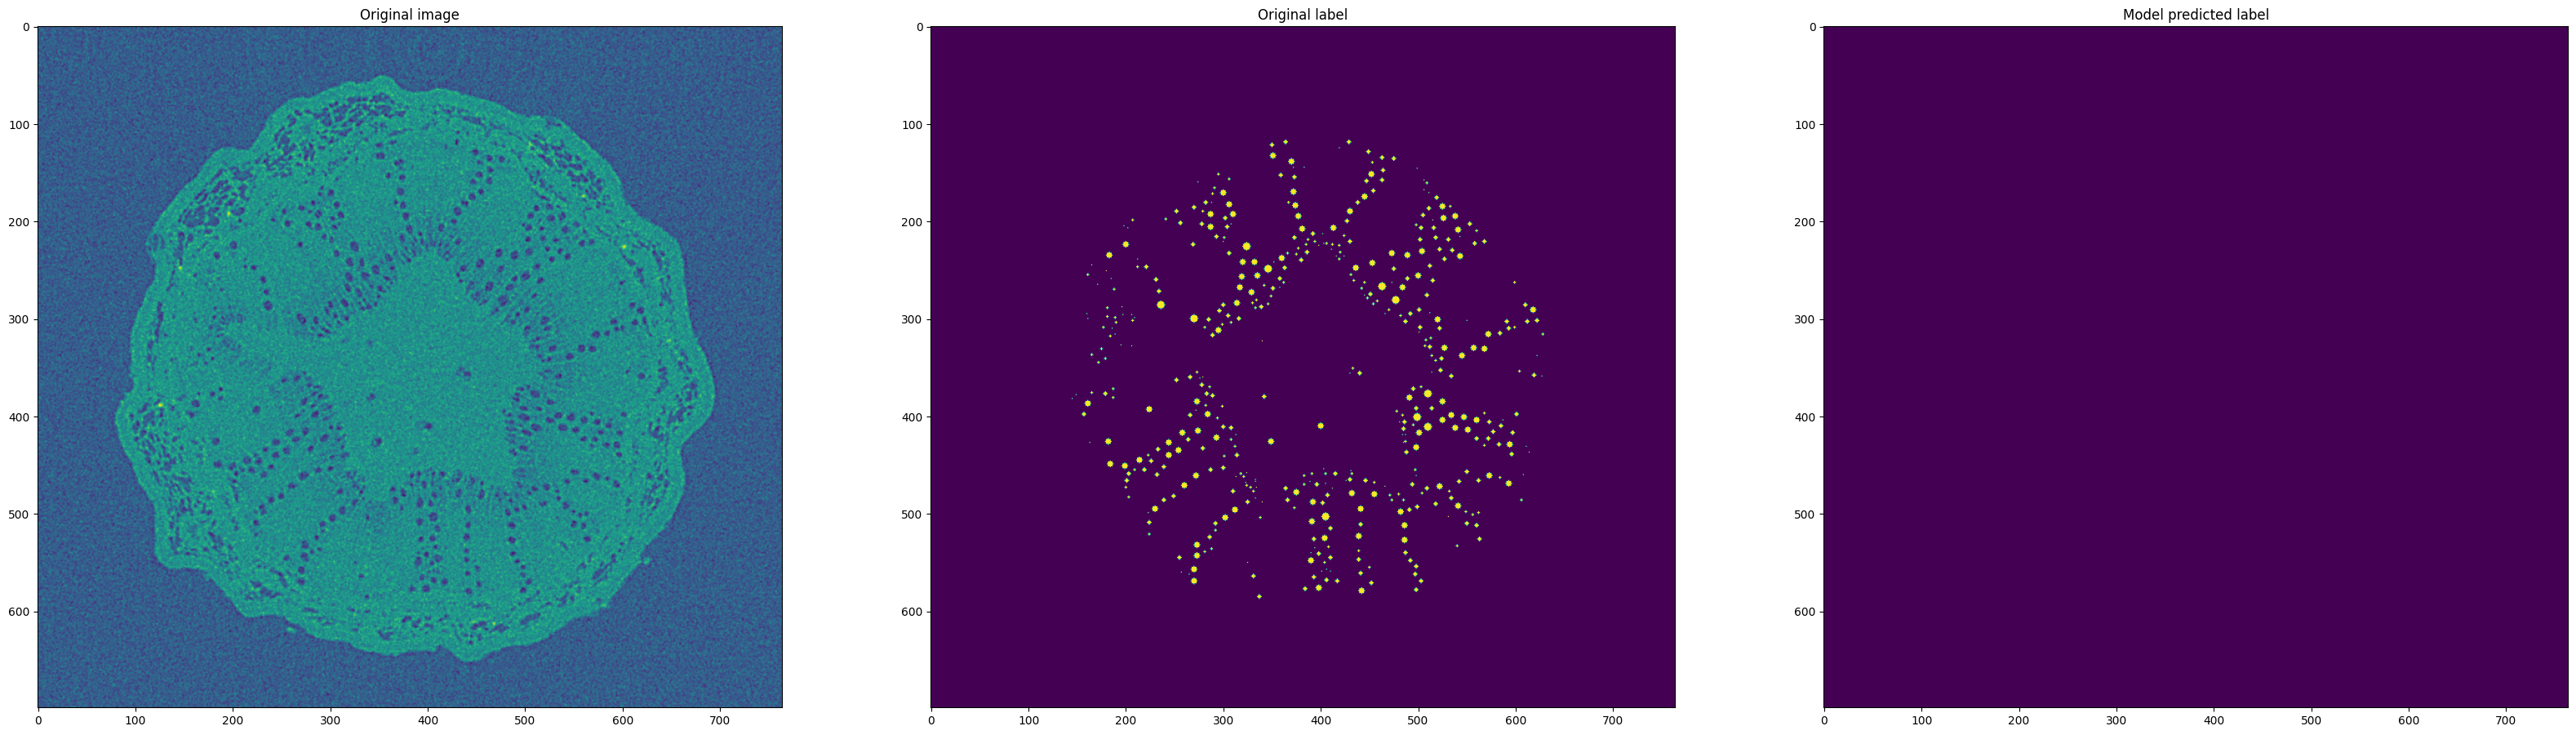

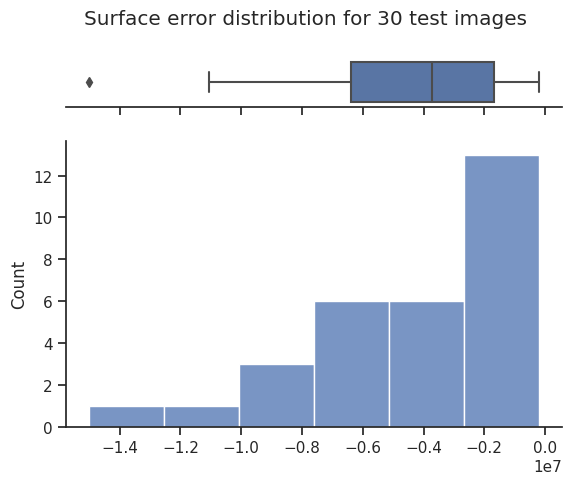

Finished testing with mean surface error=-4449740.0%


In [22]:
# Test predictions
def test_predictions(model, test_img_pathnames, test_label_pathnames):
    emb_surf_pred_errors_list = []

    print("Starting testing predictions \n")

    for img_i in range(len(test_img_pathnames)):
        test_img = cv.imread(test_img_pathnames[img_i], cv.IMREAD_UNCHANGED)
        test_label = png_to_mask(cv.imread(test_label_pathnames[img_i], cv.IMREAD_UNCHANGED))

        pred_label = out_predict(model, test_img, device)

        emb_surf_pred_error = compute_emb_surf_pred_error(test_label, pred_label, print_values=False)
        if print_each_test_stat == True:
            print(f"Emb surf pred err={emb_surf_pred_error}%")
            print(f"Confusion values are :{confusion(pred_label, test_label, data_type='numpy')}")
        else:
            print(".", end="")
        emb_surf_pred_errors_list.append(emb_surf_pred_error)

        if img_i == len(test_img_pathnames)-1:
            print("\nLast image looks like :")
            _ , axs = plt.subplots(ncols=3, figsize=(40, 40))

            axs[0].set_title("Original image")
            axs[0].imshow(test_img)

            axs[1].set_title("Original label")
            axs[1].imshow(test_label)

            axs[2].set_title("Model predicted label")
            axs[2].imshow(pred_label)
            plt.show()

    # Draw histogram with boxplot of surface error values
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    f.suptitle(f"Surface error distribution for {test_img_stop-test_img_start} test images")
    sns.boxplot(x=emb_surf_pred_errors_list, ax=ax_box)
    sns.histplot(x=emb_surf_pred_errors_list, ax=ax_hist)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()
    plt.style.use('default')

    print(f"Finished testing with mean surface error={np.mean(emb_surf_pred_errors_list)}%")
    
test_predictions(model, test_img_pathnames, test_label_pathnames)

if train_or_load == "train":
    print("\n\nCheck of performance on training set :")
    test_predictions(model, train_img_pathnames, train_label_pathnames)

In [23]:
# Saving the model
if train_or_load == "train":
    print(f"Remember to set a model name that makes it easy to identify")
    print(f"Here are the notebook parameters : \ncriterion={criterion} \noptimizer={optimizer} \nlr={learning_rate}, \nepochs={num_epochs}")
    
    PATH = "/content/drive/MyDrive/savedmodels/" + model_name + ".pkl"
    if env == "local":
        PATH = "./savedmodels/" + model_name + ".pkl"

    print("\nmodel_name = " + model_name)
    print("model_description = " + model_description)
    print("PATH = " + PATH)
    # Warning : only save once name and descriptions are set correctly
    torch.save({
            'name': model_name,
            'description': model_description,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(), # Only needed when planning to resume training from loaded model
            }, PATH)
    print("Model saved !")

Remember to set a model name that makes it easy to identify
Here are the notebook parameters : 
criterion=CrossEntropyLoss() 
optimizer=SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0
    nesterov: False
    weight_decay: 0
) 
lr=0.0001, 
epochs=30

model_name = 30epoch30firstImgLr1e-4SGDnoInertiaCrossEntro
model_description = None
PATH = /content/drive/MyDrive/savedmodels/30epoch30firstImgLr1e-4SGDnoInertiaCrossEntro.pkl
Model saved !
